In [74]:
import random
import csv
import os

In [75]:
# Function to generate distances for 10 cities with a specified range of connections
def generate_distances_10(num_of_cities, min_connections=2, max_connections=7):
    random.seed(42)
    # Create a 2D list (distances) of size nxn (initializes an empty distance matrix)
    distances = []
    for _ in range(num_of_cities):
        row = [None] * num_of_cities
        distances.append(row)

    connections = [0] * num_of_cities

    for i in range(num_of_cities):
        # Ensure each city has at least the minimum number of connections
        while connections[i] < min_connections:
            j = random.randint(0, num_of_cities - 1) # random integer represent another city.
            if i != j and distances[i][j] is None:
                distance = random.randint(3, 50) #generate a random distance between 3 and 50
                distances[i][j] = distance
                distances[j][i] = distance
                connections[i] += 1
                connections[j] += 1

        # Add additional connections without exceeding the maximum allowed
        possible = [] # list of cities that can be connected to city i
        for j in range(num_of_cities):
            #not the same city, no existing connection, and the city can accept more connections
            if i != j and distances[i][j] is None and connections[j] < max_connections:
                possible.append(j)

        random.shuffle(possible)
        #Calculate the number of additional connections city i can have without exceed maximum allowed
        extra_connections = min(max_connections - connections[i], len(possible))
        for j in possible[:extra_connections]:
            distance = random.randint(3, 50)
            distances[i][j] = distance
            distances[j][i] = distance
            connections[i] += 1
            connections[j] += 1

    for i in range(num_of_cities):
        distances[i][i] = 0  # Distance to self is 0

    return distances


In [76]:
# Function to generate distances for 20 cities with a specified range of connections
def generate_distances_20(num_of_cities, min_connections=12, max_connections=17):
    random.seed(42)
    distances = []
    for _ in range(num_of_cities):
        row = [None] * num_of_cities
        distances.append(row)

    connections = [0] * num_of_cities

    for i in range(num_of_cities):
        while connections[i] < min_connections:
            j = random.randint(0, num_of_cities - 1)
            if i != j and distances[i][j] is None:
                distance = random.randint(3, 50)
                distances[i][j] = distance
                distances[j][i] = distance
                connections[i] += 1
                connections[j] += 1

        possible = []
        for j in range(num_of_cities):
            if i != j and distances[i][j] is None and connections[j] < max_connections:
                possible.append(j)

        random.shuffle(possible)
        extra_connections = min(max_connections - connections[i], len(possible))
        for j in possible[:extra_connections]:
            distance = random.randint(3, 50)
            distances[i][j] = distance
            distances[j][i] = distance
            connections[i] += 1
            connections[j] += 1

    for i in range(num_of_cities):
        distances[i][i] = 0

    return distances

In [77]:
# determine the next city to visit
def choose_next_city(current_city, visited, pheromones, distances, alpha, beta):
    # store all cities that have not been visited yet
    remaining_cities = []
    for city in range(len(distances)):
        # city has not yet been visited and accessible from current city
        if city not in visited and distances[current_city][city] is not None:
            remaining_cities.append(city)

    # there are no other moves possible
    if not remaining_cities:
        return None

    # following the heuristic that shorter paths are more desirable
    desirability = []
    for city in remaining_cities:
        inverse_distance = 1 / distances[current_city][city]
        desirability.append(inverse_distance)

    # compute probabilities using pheromones and desirability
    probabilities = []
    for idx, city in enumerate(remaining_cities):
        # effect of the pheromone on choosing the path to the power of alpha
        pheromone_effect = pheromones[current_city][city] ** alpha
        # effect of distance to the power of beta
        heuristic_effect = desirability[idx] ** beta
        probability = pheromone_effect * heuristic_effect
        probabilities.append(probability)

    # normalize probabilities
    total_probability = sum(probabilities)
    probabilities = [p / total_probability for p in probabilities]

    # slect next city randomly based on the calculated probabilities
    return random.choices(remaining_cities, weights=probabilities, k=1)[0]


In [78]:
# calculate total travel distance of a tour
def calculate_tour_cost(tour, distances):
    cost = 0
    # loop over each pair of consecutive cities in the tour list
    for i in range(len(tour) - 1):
        # calculates the distance between each pair of consecutive cities
        cost += distances[tour[i]][tour[i+1]]
    # adds the distance between the last city and the first city
    cost += distances[tour[-1]][tour[0]]
    return cost

In [79]:
# updates a pheromone matrix according to a tour and its associated cost
def update_pheromones(pheromones, tour, cost):
    # rate at which the pheromones decrease over time
    evaporation_rate = 0.4
    # lower cost tours deposit more pheromones so they are more attractive
    pheromone_deposit = 1 / cost

    # loop over each pair of consecutive cities
    for i in range(len(tour) - 1):
        # update pheromone level between them
        pheromones[tour[i]][tour[i+1]] += pheromone_deposit
        pheromones[tour[i+1]][tour[i]] += pheromone_deposit

    # update for return to starting city
    pheromones[tour[-1]][tour[0]] += pheromone_deposit
    pheromones[tour[0]][tour[-1]] += pheromone_deposit

    # Evaporate pheromones by rate 40% after each iteration
    for i in range(len(pheromones)):
        for j in range(len(pheromones[i])):
            if pheromones[i][j] is not None:
                # reducing the attractiveness of paths not being used recently
                pheromones[i][j] *= (1 - evaporation_rate)

In [80]:
def ant_colony_optimization(n, num_ants, num_iterations, distances, alpha, beta, best_tour_csv, pheromone_csv, print_pheromones_every=10):
    # Initialize pheromone matrix to all pairs of cities
    pheromones = []
    for i in range(n):
        pheromone_row = []
        for j in range(n):
            # Set initial pheromone level to 1 if there is a path between cities, None otherwise
            if distances[i][j] is not None:
                pheromone_row.append(1)
            else:
                pheromone_row.append(None)
        pheromones.append(pheromone_row)

    best_tour = None
    best_cost = float('inf')

    # CSV setup for recording iteration results
    with open(best_tour_csv, 'w', newline='') as best_tour_file:
        tour_writer = csv.writer(best_tour_file)
        tour_writer.writerow(['Iteration', 'Best Tour', 'Best Cost'])

        # Iterate according to the given number of iterations
        for iteration in range(num_iterations):
            iteration_best_tour = None
            iteration_best_cost = float('inf')
            for ant in range(num_ants):
                # Each ant starts a tour from a city chosen randomly
                tour = [random.randint(0, n - 1)]
                # Keep track of visited cities
                visited = set(tour)

                # loop until ant has visited all cities only once
                while len(tour) < n:
                    # current city where the ant will look for the next city to visit
                    current_city = tour[-1]
                    next_city = choose_next_city(current_city, visited, pheromones, distances, alpha, beta)
                    # if no unvisited cities are unaccessible due to the probability function or unreachable
                    if next_city is None:
                        break
                    # if finding a next city
                    tour.append(next_city)
                    visited.add(next_city)

                # checks if the ant has completed a full tour
                if len(tour) == n and distances[tour[-1]][tour[0]] is not None:
                    # calculate total distance
                    tour_cost = calculate_tour_cost(tour, distances)
                    # if less that best cost, update it
                    if tour_cost < iteration_best_cost:
                        iteration_best_tour = tour
                        iteration_best_cost = tour_cost

            # checks if best tour found in the current iteration is better than the best tour found in all previous iterations
            if iteration_best_tour and iteration_best_cost < best_cost:
                best_tour = iteration_best_tour
                best_cost = iteration_best_cost

            # Update pheromones based on the iteration's best tour
            if iteration_best_tour:
                # increases the pheromone level on paths that are part of shorter tours
                # decrease all other pheromone levels to prevent it from converging to a local optimum
                update_pheromones(pheromones, iteration_best_tour, iteration_best_cost)

            # Record current iteration's best results to CSV
            best_tour_file.write(f"Iteration: {iteration + 1}, Best Tour: {best_tour}, Best Cost: {best_cost}\n")

            # Save pheromone map to a CSV file every specified number of iterations
            if (iteration + 1) % print_pheromones_every == 0:
                with open(pheromone_csv.format(num_ants=num_ants, iteration=iteration + 1), 'w') as p_file:
                    for i, row in enumerate(pheromones):
                        p_file.write(f"{i}:" + ",".join(f"{pher:.3f}" if pher is not None else "0.000" for pher in row) + "\n")


    return best_tour, best_cost

In [81]:
# Test the system with different setups
num_iterations = 50

# Testing with 10 and 20 cities
cities_counts = [10, 20]
ant_counts = [1, 5, 10, 20]

for num_cities in cities_counts:
    distances = generate_distances_10(num_cities) if num_cities == 10 else generate_distances_20(num_cities)
    print(f"\nDistance Matrix for {num_cities} Cities:")
    for row in distances:
        print(row)
    print(f"\nRunning ACO for {num_cities} cities with various ant agents:")

    for num_ants in ant_counts:
        best_tour_csv = f"best_tour_{num_cities}_cities_{num_ants}_ants.csv"
        pheromone_csv_template = f"pheromone_map_{num_cities}_cities_{{num_ants}}_ants_{{iteration}}.csv"
        
        print(f"\n{num_ants} ant(s):")
        best_tour, best_cost = ant_colony_optimization(
            num_cities, num_ants, num_iterations, distances,
            alpha=0.1, beta=1.0,
            best_tour_csv=best_tour_csv,
            pheromone_csv=pheromone_csv_template,
            print_pheromones_every=10
        )

        print(f"Best Tour ({num_cities} cities, {num_ants} ants): {best_tour}")
        print(f"Best Cost ({num_cities} cities, {num_ants} ants): {best_cost}")


Distance Matrix for 10 Cities:
[0, 4, 17, None, 18, 8, 5, 16, 4, None]
[4, 0, None, 47, 40, 13, None, 20, 41, 3]
[17, None, 0, 27, 25, None, 24, 9, 25, 8]
[None, 47, 27, 0, 8, 10, 38, 37, None, 27]
[18, 40, 25, 8, 0, 7, 48, None, 5, None]
[8, 13, None, 10, 7, 0, 9, None, 17, 27]
[5, None, 24, 38, 48, 9, 0, 43, None, 26]
[16, 20, 9, 37, None, None, 43, 0, 25, 26]
[4, 41, 25, None, 5, 17, None, 25, 0, 16]
[None, 3, 8, 27, None, 27, 26, 26, 16, 0]

Running ACO for 10 cities with various ant agents:

1 ant(s):
Best Tour (10 cities, 1 ants): [8, 0, 1, 9, 2, 7, 6, 5, 3, 4]
Best Cost (10 cities, 1 ants): 103

5 ant(s):
Best Tour (10 cities, 5 ants): [5, 6, 0, 1, 9, 2, 7, 8, 4, 3]
Best Cost (10 cities, 5 ants): 86

10 ant(s):
Best Tour (10 cities, 10 ants): [7, 2, 9, 1, 0, 6, 5, 3, 4, 8]
Best Cost (10 cities, 10 ants): 86

20 ant(s):
Best Tour (10 cities, 20 ants): [6, 0, 1, 9, 2, 7, 8, 4, 3, 5]
Best Cost (10 cities, 20 ants): 86

Distance Matrix for 20 Cities:
[0, 4, 16, 4, 27, 47, 48, 11, 1

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [83]:
def plot_pheromone_development(num_cities, ant_counts, num_iterations, interval, start_iteration=10):
    print(f"Plotting pheromone development for {num_cities} cities")

    # Define the plot layout
    fig, axs = plt.subplots(len(ant_counts), figsize=(10, 5 * len(ant_counts)))
    if len(ant_counts) == 1:
        axs = [axs]  # Make it iterable if there's only one subplot

    for idx, num_ants in enumerate(ant_counts):
        ax = axs[idx]
        pheromone_levels = []

        # Gather pheromone data over iterations, starting from 'start_iteration'
        for iteration in range(start_iteration, num_iterations + 1, interval):
            csv_file = f"pheromone_map_{num_cities}_cities_{num_ants}_ants_{iteration}.csv"
            if os.path.exists(csv_file):
                data = pd.read_csv(csv_file, header=None)
                data = data[0].apply(lambda x: x.split(':')[1])  # Process each row, splitting and taking the second part
                data = data.apply(lambda x: [float(i) for i in x.split(',')])  # Convert string values to list of floats
                average_pheromone = data.apply(pd.Series).stack().mean()  # Calculate the overall mean from the list
                pheromone_levels.append(average_pheromone)
            else:
                print(f"Missing CSV file: {csv_file}")
                pheromone_levels.append(None)

        ax.plot(range(start_iteration, num_iterations + 1, interval), pheromone_levels, label=f'{num_ants} ants')
        ax.set_title(f'Pheromone Levels over Time ({num_ants} ants)')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Average Pheromone Level')
        ax.legend()

    plt.tight_layout()
    plt.show()

Plotting pheromone development for 10 cities


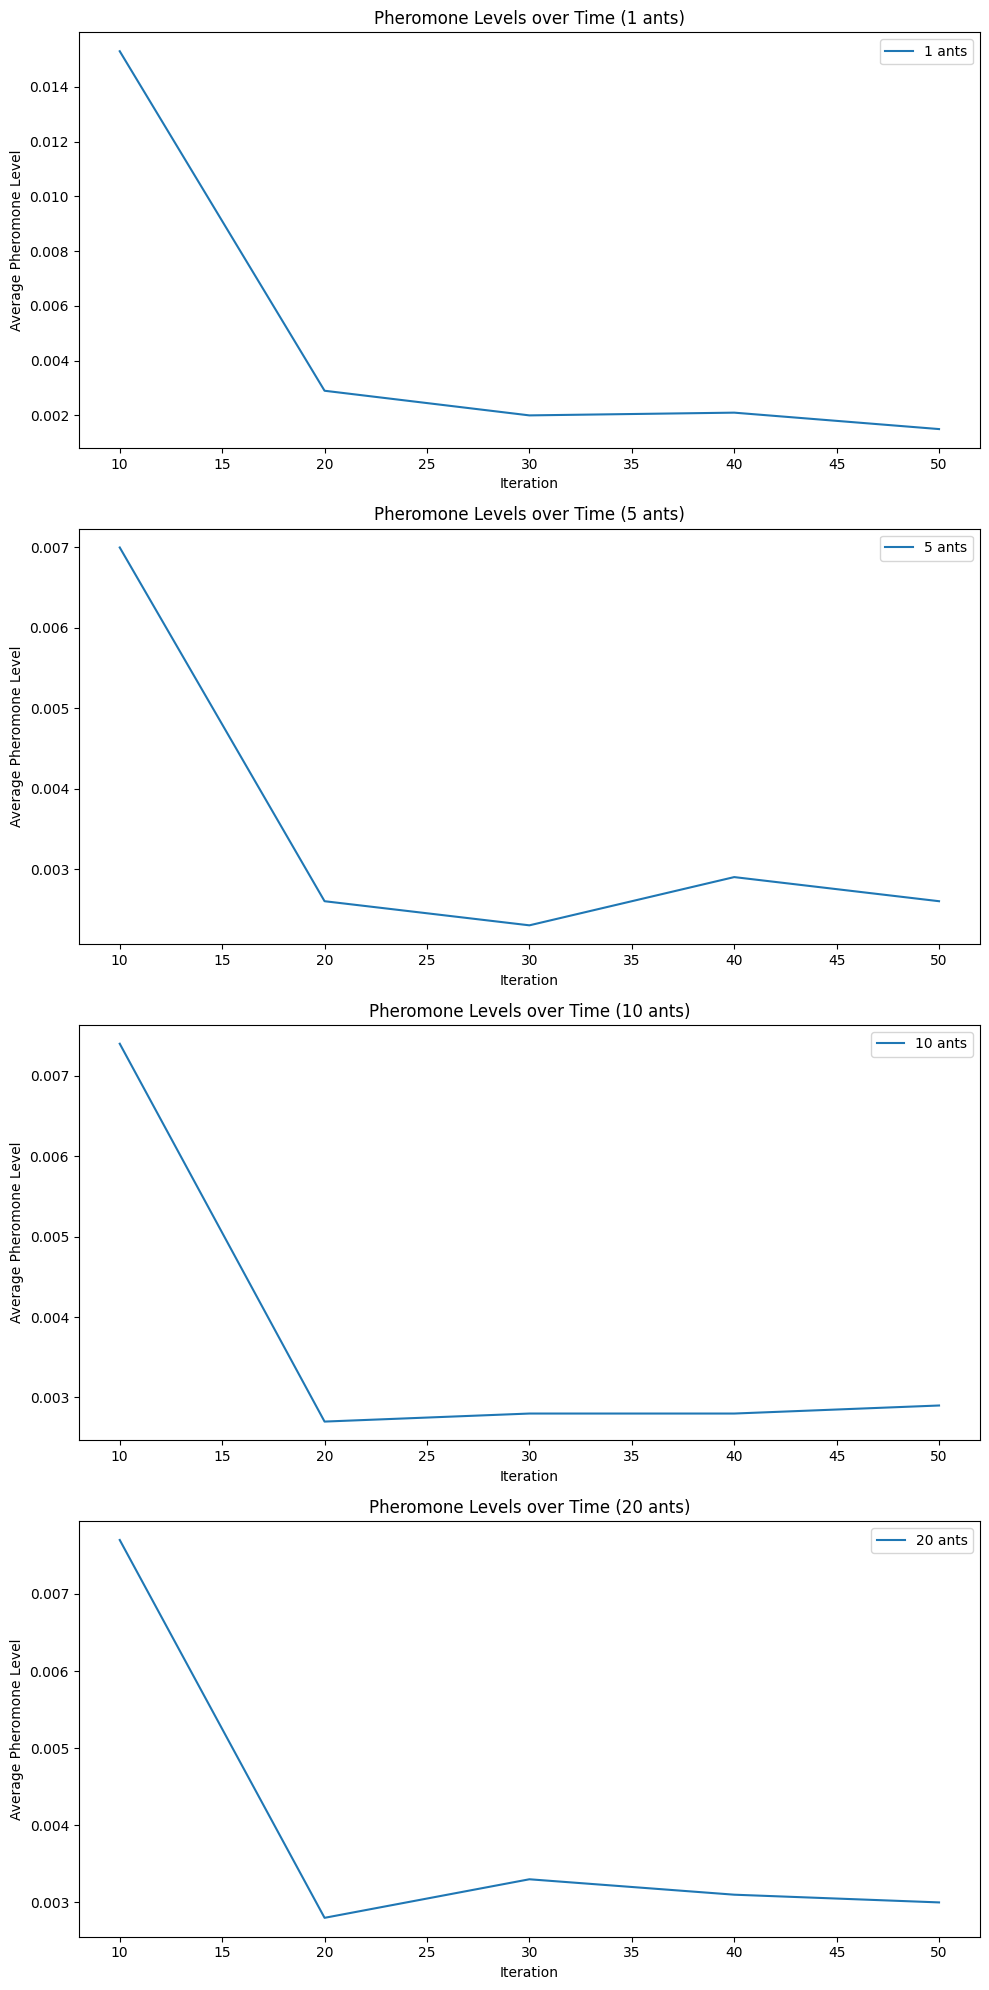

Plotting pheromone development for 20 cities


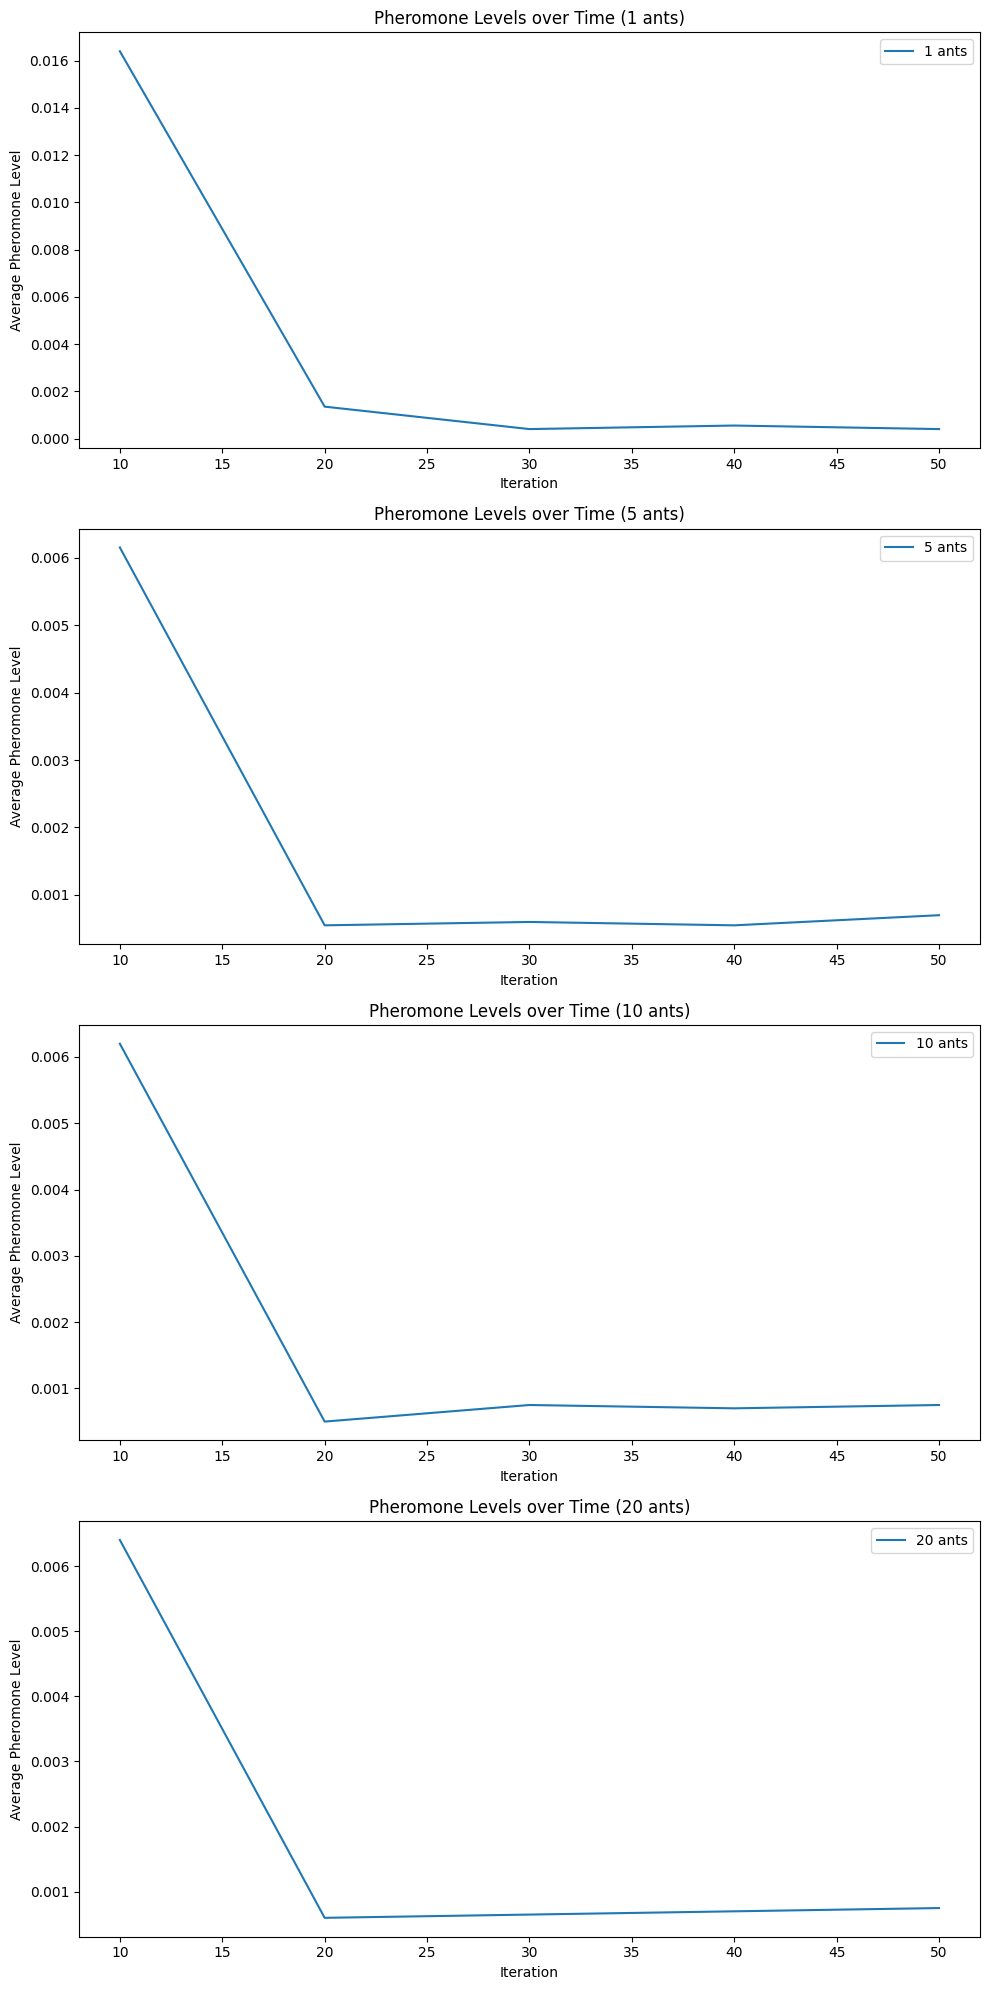

In [84]:
plot_pheromone_development(10, [1, 5, 10, 20], 50, 10)
plot_pheromone_development(20, [1, 5, 10, 20], 50, 10)

In [85]:
def avg_pheromone_development(city_counts, ant_counts, num_iterations, interval, start_iteration=10):
    # Iterate over each city count to create separate plots
    for num_cities in city_counts:
        print(f"Plotting pheromone development for {num_cities} cities")

        # Create a figure for the current number of cities
        plt.figure(figsize=(10, 5))
        for num_ants in ant_counts:
            pheromone_levels = []

            # Gather pheromone data over iterations, starting from 'start_iteration'
            for iteration in range(start_iteration, num_iterations + 1, interval):
                csv_file = f"pheromone_map_{num_cities}_cities_{num_ants}_ants_{iteration}.csv"
                if os.path.exists(csv_file):
                    data = pd.read_csv(csv_file, header=None)
                    data = data[0].apply(lambda x: x.split(':')[1])  # Process each row, splitting and taking the second part
                    data = data.apply(lambda x: [float(i) for i in x.split(',')])  # Convert string values to list of floats
                    average_pheromone = data.apply(pd.Series).stack().mean()  # Calculate the overall mean from the list
                    pheromone_levels.append(average_pheromone)
                else:
                    print(f"Missing CSV file: {csv_file}")
                    pheromone_levels.append(None)

            plt.plot(range(start_iteration, num_iterations + 1, interval), pheromone_levels, label=f'{num_ants} ants')

        plt.title(f'Pheromone Levels over Time ({num_cities} cities)')
        plt.xlabel('Iteration')
        plt.ylabel('Average Pheromone Level')
        plt.legend()
        plt.tight_layout()
        plt.show()

Plotting pheromone development for 10 cities


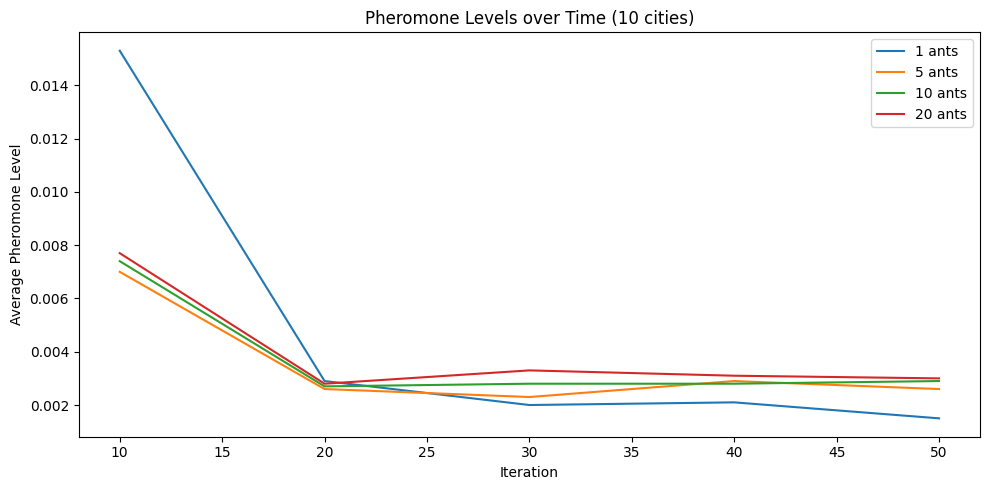

Plotting pheromone development for 20 cities


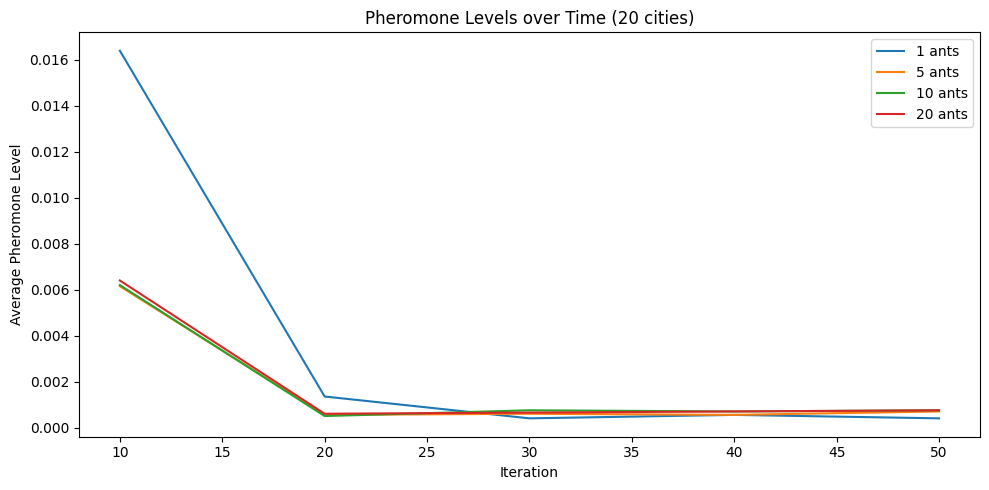

In [86]:
avg_pheromone_development([10, 20], [1, 5, 10, 20], 50, 10)

In [87]:
def parse_custom_csv(filename):
    # Parse the CSV with custom logic
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    iterations = []
    best_costs = []
    
    for line in lines[1:]:  # Skip the header
        parts = line.split(',')
        if len(parts) < 3:
            continue
        iteration_info = parts[0].strip()
        best_cost_info = parts[-1].strip()

        iteration_number = iteration_info.split(' ')[1]
        best_cost = best_cost_info.split(':')[-1].strip()

        iterations.append(int(iteration_number))
        best_costs.append(float(best_cost))
    
    return iterations, best_costs



In [88]:
def plot_best_route_development(city_count, ant_counts, max_iterations):
    plt.figure(figsize=(10, 6))
    
    for num_ants in ant_counts:
        filename = f"best_tour_{city_count}_cities_{num_ants}_ants.csv"
        try:
            iterations, best_costs = parse_custom_csv(filename)
            # Select every 10th iteration to reduce data density
            selected_iterations = iterations[::10]
            selected_costs = best_costs[::10]
            plt.plot(selected_iterations, selected_costs, label=f'{num_ants} ants')
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    
    plt.title(f"Development of Best Route Cost over Iterations ({city_count} cities)")
    plt.xlabel('Iteration')
    plt.ylabel('Cost of Best Route')
    plt.legend()
    plt.show()


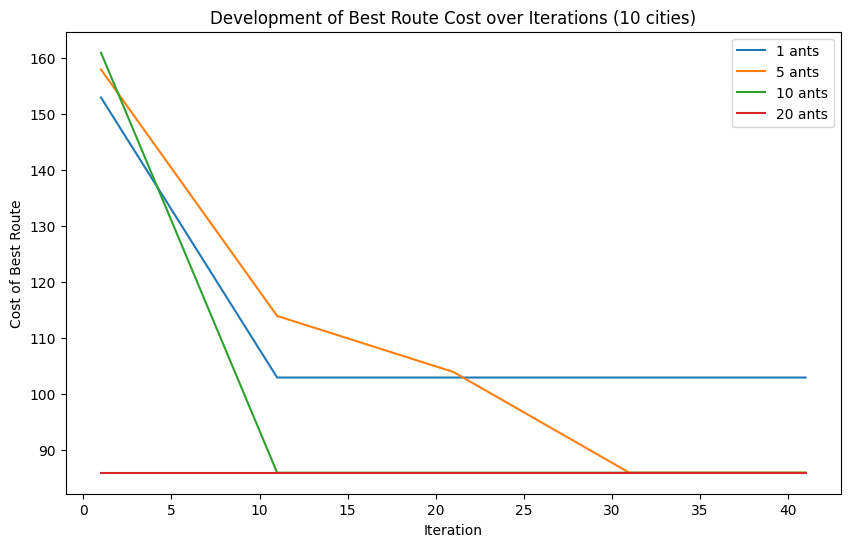

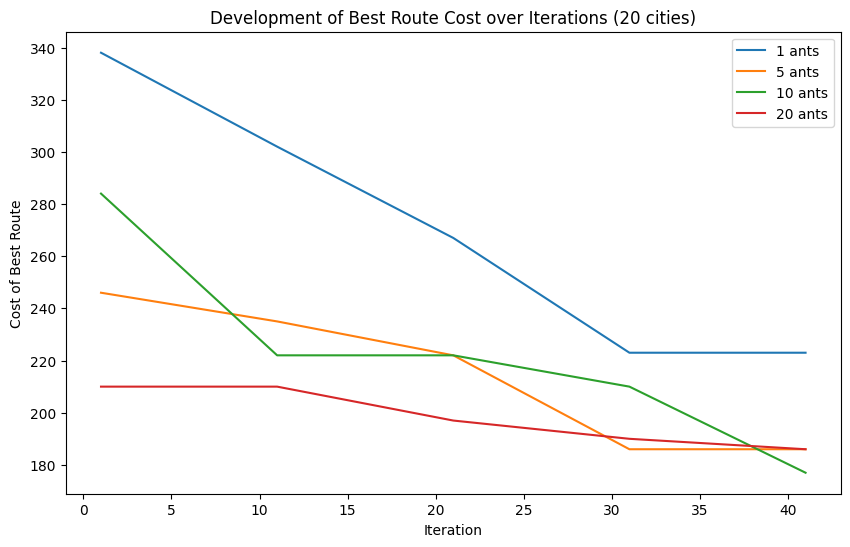

In [89]:
# Example usage
plot_best_route_development(10, [1, 5, 10, 20], 50)
plot_best_route_development(20, [1, 5, 10, 20], 50)